In [1]:
import netCDF4 as nc
import os
import numpy as np
import pandas as pd

## Нужная переменная zos (sea_surface_height_above_geoid)

In [177]:
nemo_data_folder='./dataset_SPITZ12'
test_file=os.path.join(nemo_data_folder, os.listdir(nemo_data_folder)[0])
ds = nc.Dataset(test_file)
#for var in ds.variables.values():
    #print(var)
print(np.array(ds['zos']).shape)

(1, 115, 117)


## Извлечение индекса ячейки по координатам

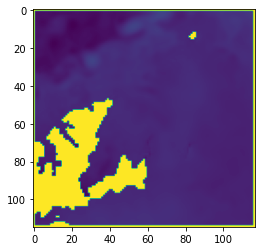

In [198]:
import matplotlib.pyplot as plt
plt.imshow(np.array(ds['zos'])[0])
# как выглядит наша переменная

In [213]:
def idx_by_2coord(coordinate, lat_array, lon_array):
    # делаем один двумерный массив, в котором каждая ячейка содержит и широту и долготу
    coord_array=np.concatenate((np.array([np.ravel(lat_array)]).T, np.array([np.ravel(lon_array)]).T), axis=1)
    # переворачиваем его к исходной форме
    coord_array=np.reshape(coord_array, (lat_array.shape[0],lat_array.shape[1], 2))
    # вычитаем из каждой координаты нашу координату
    dif=np.abs(coord_array-coordinate)
    # суммируем модули отклонения по обеим координатам
    dis=np.sum(dif, axis=2)
    
    #plt.imshow(dis) # центр "крестика" и есть наша точка
    
    # извлекаем индекс центра "крестика"
    geo_idx = np.unravel_index(dis.argmin(), dis.shape)
    return geo_idx

(28, 68)

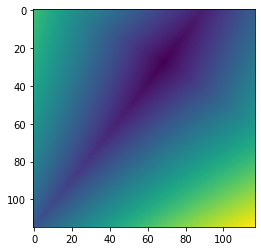

In [212]:
idx_by_2coord([75.295924, 18.454331], np.array(ds['nav_lat']), np.array(ds['nav_lon']))

### *NEMO запустила на отдельный день в отдельном файле* 

## Формируем словарь

In [214]:
coordinates_from_map={'lat':[75.295924, 77.325956],
                      'lon':[18.454331, 29.460769]}

dates_list=[]
names_dict={}

for i in range (len(coordinates_from_map['lat'])):
    name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
    names_dict[name]=[]
print(names_dict)

for file in os.listdir(nemo_data_folder):
    #print(file)        
    try:
        ds = nc.Dataset(os.path.join(nemo_data_folder, file))
    except Exception as e:
        print(e)
        pass
    date='2'+file.split('_')[-1].split('-')[-2][1:]
    
    dates_list.append(date)
        
    for i in range (len(coordinates_from_map['lat'])):        
        
        sea_level=np.array(ds['zos'][:, :, :])[0]

        in_lat = coordinates_from_map['lat'][i]
        in_lon = coordinates_from_map['lon'][i]

        lats = np.array(ds['nav_lat'])
        lons = np.array(ds['nav_lon'])

        idx = idx_by_2coord([in_lat, in_lon], lats, lons)

        value=sea_level[idx[0], idx[1]]
        name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
        names_dict[name].append(value)
names_dict['dates']=dates_list

{'75.295924_18.454331': [], '77.325956_29.460769': []}
[Errno -51] NetCDF: Unknown file format: b'./dataset_SPITZ12\\SPITZ_1d_00010101_00011231_grid_T_00010102-00010102.nc.aux.xml'


## Датафрейм с временными рядами

In [215]:
pd_df = pd.DataFrame(names_dict, columns = list(names_dict.keys()))
pd_df['dates'] =  pd.to_datetime(pd_df['dates'], format='%Y%m%d')
pd_df=pd_df.sort_values(by=['dates'])
pd_df

,75.295924_18.454331,77.325956_29.460769,dates
0,-0.859156,-0.878790,2001-01-01
1,-0.893065,-0.891311,2001-01-02
2,-0.893065,-0.891311,2001-01-02
3,-0.885121,-0.900473,2001-01-03
4,-0.877156,-0.892680,2001-01-04
5,-0.875587,-0.891211,2001-01-05
6,-0.855830,-0.877558,2001-01-06
7,-0.857229,-0.854486,2001-01-07
8,-0.855984,-0.849194,2001-01-08
9,-0.873569,-0.862442,2001-01-09
